# Лабораторная работа №1
# Градиентный спуск и его модификации
# Задание на лабораторную работу:
- Выбрать тестовые функции оптимизации (2 шт)
- Запрограммировать собственную реализацию классического градиентного спуска
- Запрограммировать пайлайн тестирования алгоритма оптимизации
    - Визуализации функции и точки оптимума
    - Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
    - Визуализации точки найденного решения (можно добавить анимацию на плюс балл)
- Запрограммировать метод вычисления градиента
    - Передача функции градиента от пользователя
    - Символьное вычисление градиента (например с помощью sympy) (на доп балл)
    - Численная аппроксимация градиента (на доп балл)
- Запрограммировать одну моментную модификацию и протестировать ее
- Запрограммировать одну адаптивную модификацию и протестировать ее
- Запрограммировать метод эволюции темпа обучения и/или метод выбора начального приближения и протестировать их
## В качестве тестовых функций были выбраны: 
## Функция Бута и Функция Леви N 13 

In [157]:
from abc import ABC, abstractmethod

import numpy
import numpy as np
from matplotlib import pyplot as plt

In [158]:
class TestFunction(ABC):
    def __init__(self):
        self.title = 'Test Function'
        self.minimum = np.array([0, 0, 0])
        self.bounds = np.array([[-4.5, 4.5], [-4.5, 4.5]])

    @abstractmethod
    def function(self, x):
        pass

    @abstractmethod
    def gradient(self, x):
        pass

In [159]:
class BoothFunction(TestFunction):
    def __init__(self):
        super().__init__()
        self.title = "Booth's Function"
        self.minimum = np.array([1, 3, 0])

    def function(self, args: np.array):
        x, y = args[:2]
        return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    def gradient(self, args: np.array):
        x, y = args[:2]
        df_dx = 10 * x + 8 * y - 34
        df_dy = 8 * x + 10 * y - 38
        return np.array([df_dx, df_dy])

In [160]:
class LevyFunction(TestFunction):
    def __init__(self):
        super().__init__()
        self.title = "Levy Function N. 13"
        self.minimum = np.array([1, 1, 0])

    def function(self, args: np.array):
        x, y = args[:2]
        return (numpy.sin(3 * numpy.pi * x) ** 2 +
                (x - 1) ** 2 * (1 + numpy.sin(3 * numpy.pi * y) ** 2) +
                (y - 1) ** 2 * (1 + numpy.sin(2 * numpy.pi * x) ** 2))

    def gradient(self, args: np.array):
        x, y = args[:2]
        df_dx = ((2 * x - 2) * (numpy.sin(3 * numpy.pi * y) ** 2 + 1) +
                 4 * numpy.pi * (y - 1) ** 2 * numpy.sin(2 * numpy.pi * x) *
                 numpy.cos(2 * numpy.pi * x) +
                 6 * numpy.pi * numpy.sin(3 * numpy.pi * x) * numpy.cos(3 * numpy.pi * x))
        df_dy = (6 * numpy.pi * (x - 1) ** 2 * numpy.sin(3 * numpy.pi * y) *
                 numpy.cos(3 * numpy.pi * y) +
                 (2 * y - 2) * (numpy.sin(2 * numpy.pi * x) ** 2 + 1))
        return np.array([df_dx, df_dy])

In [176]:
class GradientDescent:
    @staticmethod
    def calculate_gd(test: TestFunction,
                     initial_point: np.array,
                     num_iterations: int,
                     learning_rate: float,
                     convergence_radius=0.001) -> np.array:

        """Расчёт градиентного спуска
                Args:
                    test (TestFunction): объект класса тестовой функции оптимизации
                    initial_point (np.array): начальная точка градиента
                    num_iterations (int): количество итераций
                    learning_rate (float): размер шага для каждой итерации
                    convergence_radius (float): радиус сходимости
        """

        params = initial_point.copy()
        history = [np.array([params[0], params[1], test.function(params)])]

        for current_iteration in range(num_iterations):
            params = params - learning_rate * test.gradient(params)
            if current_iteration % 5 == 0:
                history.append(np.array([params[0], params[1], test.function(params)]))
            if np.abs(history[-2][-1] - history[-1][-1]) < convergence_radius:
                break

        return np.array(history)

    @staticmethod
    def calculate_accelerated_gd(test: TestFunction,
                                 initial_point: np.array,
                                 num_iterations: int,
                                 learning_rate: float,
                                 momentum=0.9,
                                 convergence_radius=0.001):
        """Расчёт ускоренного градиентного спуска (Nesterov Momentum)
                Args:
                    test (TestFunction): объект класса тестовой функции оптимизации
                    initial_point (np.array): начальная точка градиента
                    num_iterations (int): количество итераций
                    learning_rate (float): размер шага для каждой итерации
                    momentum (float):  параметр момента
                    convergence_radius (float): радиус сходимости
        """

        params = initial_point.copy()
        history = [np.array([params[0], params[1], test.function(params)])]
        v = np.array([0, 0])

        for current_iteration in range(num_iterations):
            v = momentum * v - learning_rate * test.gradient(params + momentum * v)
            params = params + v
            if current_iteration % 5 == 0:
                history.append(np.array([params[0], params[1], test.function(params)]))
            if np.abs(history[-2][-1] - history[-1][-1]) < convergence_radius:
                break

        return np.array(history)

    @staticmethod
    def calculate_adam(test: TestFunction,
                       initial_point: np.array,
                       num_iterations: int,
                       learning_rate: float,
                       beta_1=0.9,
                       beta_2=0.99,
                       eps=1e-8,
                       convergence_radius=0.001):
        """Расчёт Adam (ADAptive Momentum)
                Args:
                    test (TestFunction): объект класса тестовой функции оптимизации
                    initial_point (np.array): начальная точка градиента
                    num_iterations (int): количество итераций
                    learning_rate (float): размер шага для каждой итерации
                    beta_1 (float):  параметр момента
                    beta_2 (float):  параметр момента
                    eps (float):  параметр момента
                    convergence_radius (float): радиус сходимости
        """

        params = initial_point.copy()
        history = [np.array([params[0], params[1], test.function(params)])]
        v = np.array([0, 0])
        G = np.array([0, 0])

        for current_iteration in range(num_iterations):
            v = beta_1 * v + (1 - beta_1) * test.gradient(params)
            G = beta_2 * G + (1 - beta_2) * test.gradient(params) ** 2
            params = params - learning_rate * v / np.sqrt(G + eps)
            if current_iteration % 5 == 0:
                history.append(np.array([params[0], params[1], test.function(params)]))
            if np.abs(history[-2][-1] - history[-1][-1]) < convergence_radius:
                break

        return np.array(history)

    @staticmethod
    def visualize_func(test: TestFunction,
                       history: np.array,
                       gd_name: str) -> None:

        """Визуализация градиентного спуска
                Args:
                    test (TestFunction): функция тестовой функции
                    history (list): история изменения градиента
                    gd_name (str): название метода градиентного спуска
        """

        fig = plt.figure(figsize=(10, 12))  # Размер холста
        ax = fig.add_subplot(111, projection='3d')

        # Блок, отвечающий за график функции с заданными ограничениями
        x = np.linspace(test.bounds[0, 0], test.bounds[0, 1], 100)  # Заданные ограничения
        y = np.linspace(test.bounds[1, 0], test.bounds[1, 1], 100)
        X, Y = np.meshgrid(x, y)
        Z = test.function(np.array([X, Y]))  # Отрисовка функции

        # Блок, отвечающий за график градиента, а также начальную точку и точку минимума
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
        ax.plot(history[:, 0], history[:, 1], history[:, 2], '-o', c='black', label='Градиентный спуск', alpha=0.7)

        #  Отрисовка истории изменения градиента
        ax.scatter3D(history[0, 0], history[0, 1], history[0, 2],
                     s=100, c="white", lw=2, ec='black', marker='D', label="Начальная точка")
        ax.scatter3D(history[-1, 0], history[-1, 1], history[-1, 2],
                     s=190, c="white", lw=2, ec='black', marker='X', label="Найденный минимум")

        min_z = test.function(test.minimum)  # Отрисовка точки минимума
        ax.scatter(test.minimum[0], test.minimum[1], min_z, color='red', marker='o', s=100, label='Минимум')

        # Блок, отвечающий за легенду графика
        np.set_printoptions(formatter={'float_kind': "{:.2f}".format})
        print(f"Оптимизационный метод:\t{gd_name}")
        print(f"Начальная точка:\t{history[0]}")
        print(f"Найденный минимум:\t{history[-1]}")
        print(f"Глобальный минимум:\t{test.minimum}")
        print(f"Погрешность:\t{test.minimum - history[-1]}")
        print(f"Количество итераций:\t{len(history)}")

        fig.text(0.9, 0.15, s=f"Оптимизационный метод: {gd_name}", horizontalalignment="right", fontsize=12)
        fig.text(0.9, 0.1, s=f"Количество итераций: {len(history)}", horizontalalignment="right", fontsize=12)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(test.title)  # Вывод заголовка

        ax.legend(loc="upper right")
        plt.show()

Оптимизационный метод:	Classic GD
Начальная точка:	[-4.00 -4.00 650.00]
Найденный минимум:	[1.03 2.97 0.00]
Глобальный минимум:	[1 3 0]
Погрешность:	[-0.03 0.03 -0.00]
Количество итераций:	19


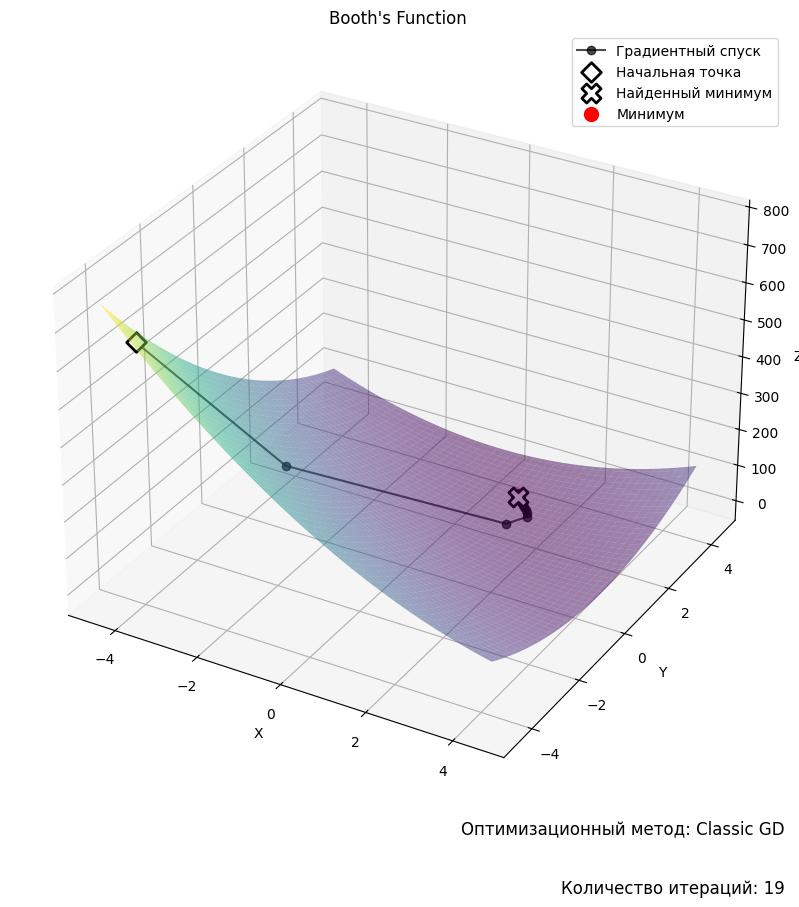

In [177]:
initial_point = np.array([-4, -4])
booth_func = BoothFunction()
history = GradientDescent.calculate_gd(booth_func,
                                       initial_point=initial_point,
                                       num_iterations=1000,
                                       learning_rate=0.02)
GradientDescent.visualize_func(booth_func, history=history, gd_name="Classic GD")

Оптимизационный метод:	Classic GD
Начальная точка:	[0.00 0.00 2.00]
Найденный минимум:	[0.67 0.73 0.27]
Глобальный минимум:	[1 1 0]
Погрешность:	[0.33 0.27 -0.27]
Количество итераций:	18


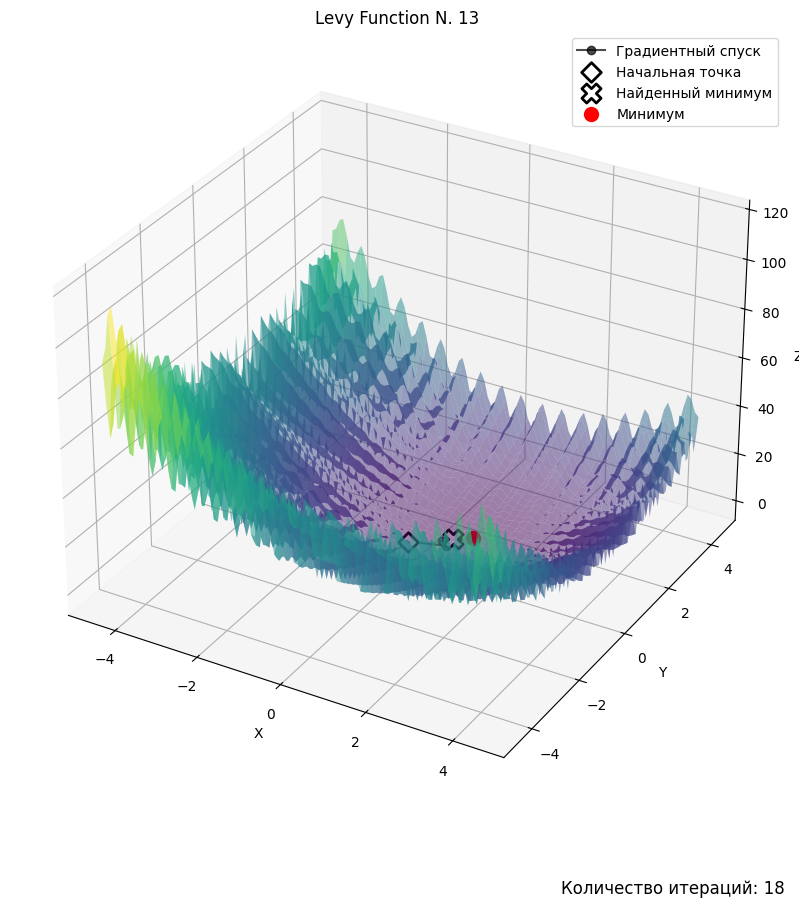

In [163]:
initial_point = np.array([0, 0])
levy_func = LevyFunction()
history = GradientDescent.calculate_gd(levy_func,
                                       initial_point=initial_point,
                                       num_iterations=1000,
                                       learning_rate=0.02)
GradientDescent.visualize_func(levy_func, history=history, gd_name="Classic GD")

Оптимизационный метод:	Nesterov Momentum GD
Начальная точка:	[-4.00 -4.00 650.00]
Найденный минимум:	[0.98 3.02 0.00]
Глобальный минимум:	[1 3 0]
Погрешность:	[0.02 -0.02 -0.00]
Количество итераций:	12


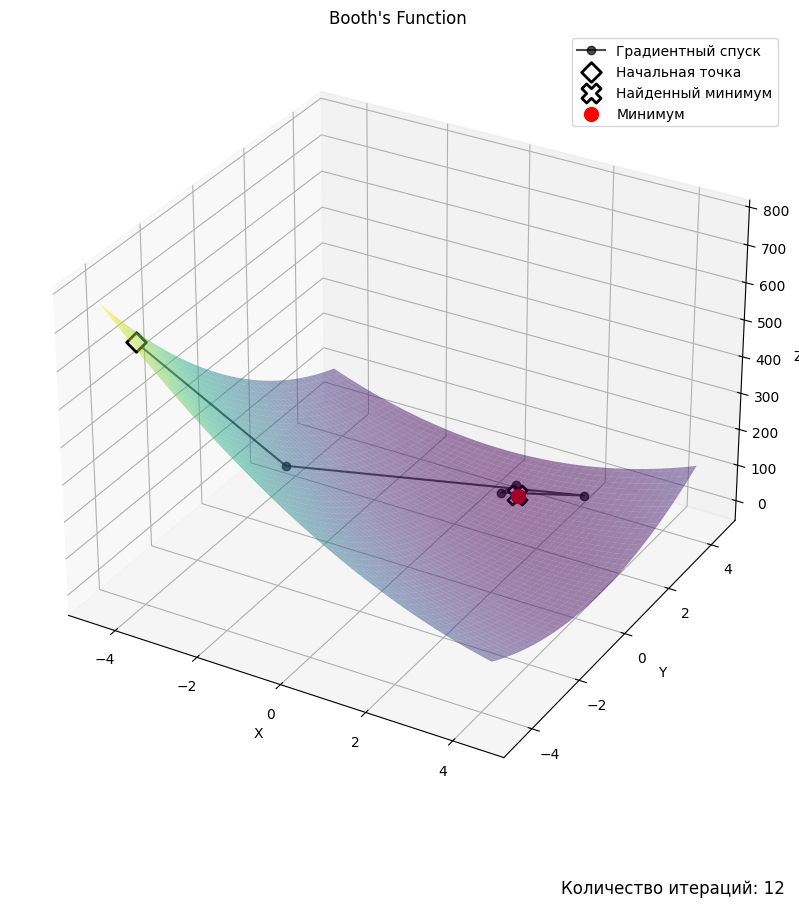

In [164]:
initial_point = np.array([-4, -4])
booth_func = BoothFunction()
history = GradientDescent.calculate_accelerated_gd(booth_func,
                                                   initial_point=initial_point,
                                                   num_iterations=1000,
                                                   learning_rate=0.02)
GradientDescent.visualize_func(booth_func, history=history, gd_name="Nesterov Momentum GD")

Оптимизационный метод:	Nesterov Momentum GD
Начальная точка:	[0.00 0.00 2.00]
Найденный минимум:	[1.02 0.98 0.05]
Глобальный минимум:	[1 1 0]
Погрешность:	[-0.02 0.02 -0.05]
Количество итераций:	40


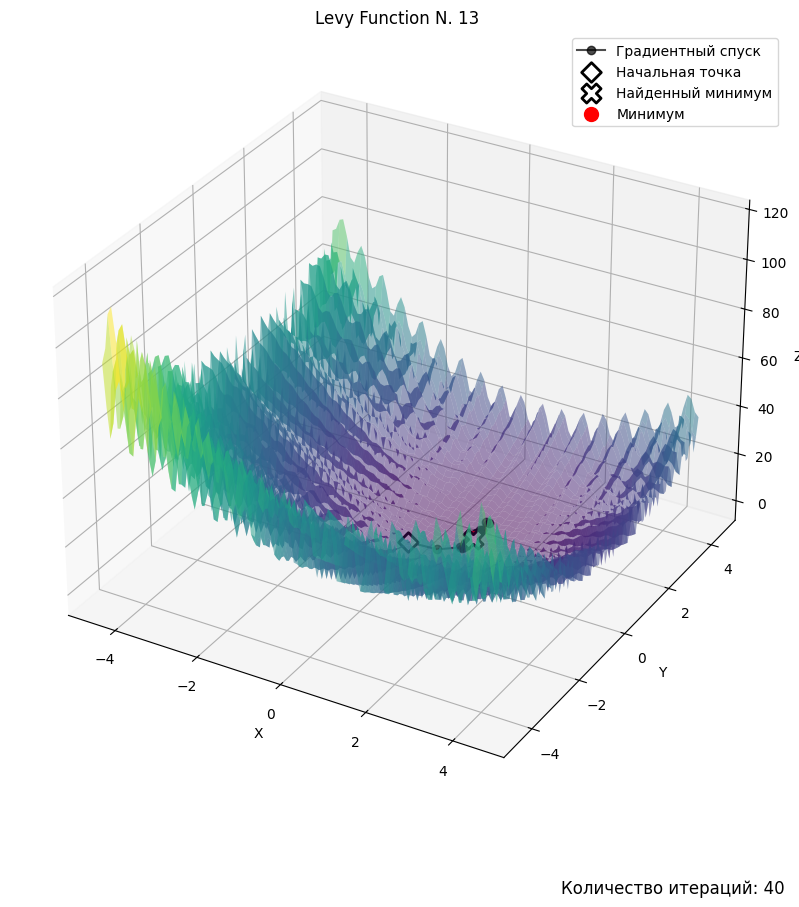

In [165]:
initial_point = np.array([0, 0])
levy_func = LevyFunction()
history = GradientDescent.calculate_accelerated_gd(levy_func,
                                                   initial_point=initial_point,
                                                   num_iterations=1000,
                                                   learning_rate=0.01,
                                                   momentum=0.995)
GradientDescent.visualize_func(levy_func, history=history, gd_name="Nesterov Momentum GD")

Оптимизационный метод:	ADAptive Momentum
Начальная точка:	[-4.00 -4.00 650.00]
Найденный минимум:	[1.05 2.95 0.01]
Глобальный минимум:	[1 3 0]
Погрешность:	[-0.05 0.05 -0.01]
Количество итераций:	161


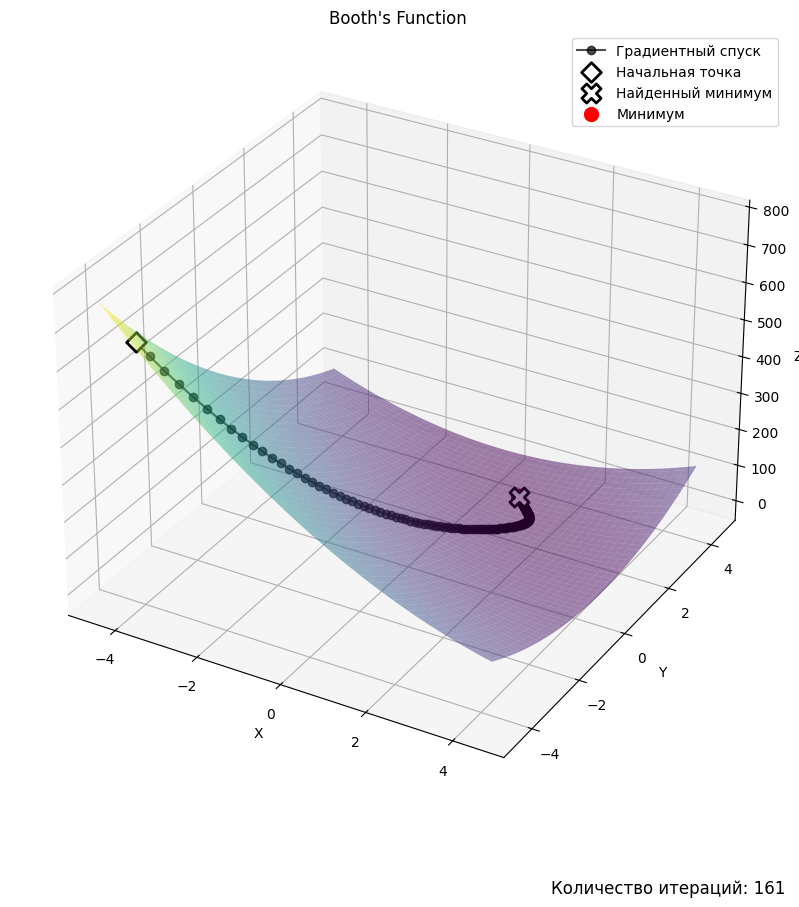

In [166]:
initial_point = np.array([-4, -4])
booth_func = BoothFunction()
history = GradientDescent.calculate_adam(booth_func,
                                         initial_point=initial_point,
                                         num_iterations=1000,
                                         learning_rate=0.02)
GradientDescent.visualize_func(booth_func, history=history, gd_name="ADAptive Momentum")

Оптимизационный метод:	ADAptive Momentum
Начальная точка:	[0.00 0.00 2.00]
Найденный минимум:	[0.01 0.01 1.98]
Глобальный минимум:	[1 1 0]
Погрешность:	[0.99 0.99 -1.98]
Количество итераций:	5


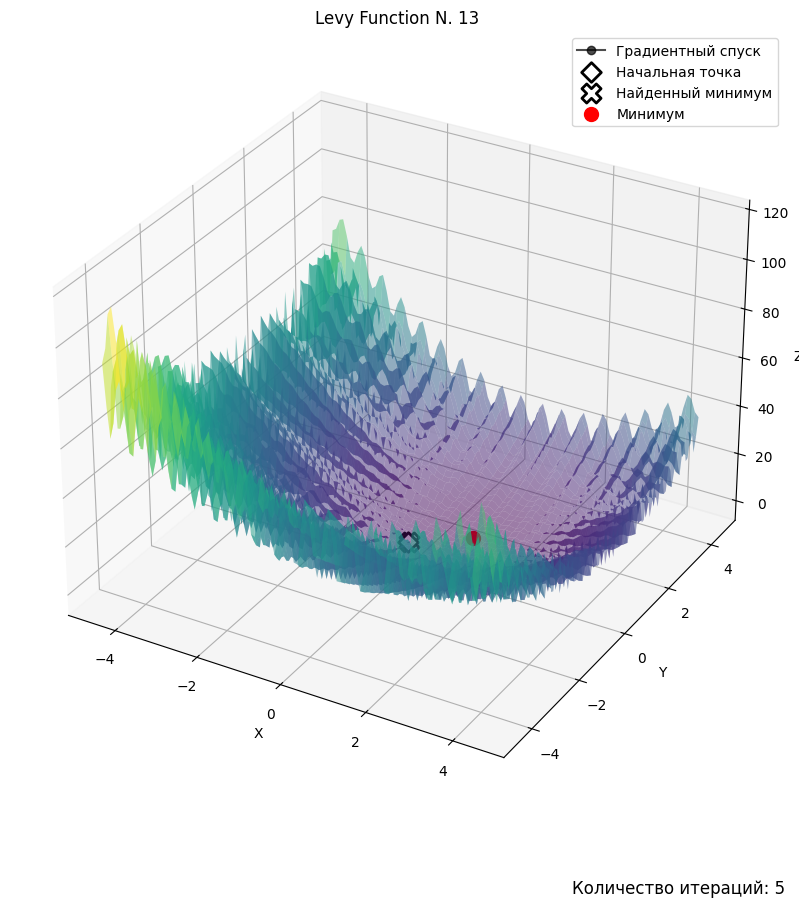

In [167]:
initial_point = np.array([0, 0])
levy_func = LevyFunction()
history = GradientDescent.calculate_adam(levy_func,
                                         initial_point=initial_point,
                                         num_iterations=1000,
                                         learning_rate=0.01)
GradientDescent.visualize_func(levy_func, history=history, gd_name="ADAptive Momentum")